# Analysis of stare processing using *wavpy*

## Basic idea

The concept of stare processing in GNSS-R basically refers to the combination of different DDM's in order to extract geophysical information from the reflecting surface based on the corresponding location of their ambiguity-free components.

In our case, we want to estimate the evolution of the probability density function of the surface's slopes as seen from different geometries. If we take an equivalent expression for the received power given in Zavarotny-Voronovich-00: 

\begin{equation}
|Y(\tau , \kappa)|^2 = \frac{P_{t}\lambda^{2}\pi}{(4\pi)^{3}L} T_{i}^2 \int_{\mathrm{surf}} \frac{G_{t}( \vec{r} ) G_{r}( \vec{r} ) |\Re_{pq}( \vec{r} )|^2}{R_{1}^{2}( \vec{r} )R_{2}^{2}( \vec{r} )} \Lambda_{C/A}^{2}(\tau + \delta \tau ( \vec{r} )) \cdot |S_{C/A}(\kappa + \delta \kappa ( \vec{r} ))|^{2} ( \frac{q( \vec{r} )}{q_z( \vec{r} )} )^4 P( - \frac{\vec{q}_{\perp}( \vec{r} )}{q_z( \vec{r} )} ) \mathrm{d}^{2}r
\end{equation}

basically we want to extract the last term in the integral $P$ from a set of values of $|Y|^2$ (the DDM minus noise power). For this purpose, we apply the following approximation:

\begin{equation}
P = |Y^{\mathrm{data}}|^2 / |Y^{\mathrm{model}}_{P=1}|^2
\end{equation}

evaluated at those delay-Doppler cells whose power response (mostly) comes from a single area over the surface (no Doppler ambiguity).

## Example case

Our example is based on a series of 58 DDM's (1-sec integration) computed by Weiqiang Li from a CYGNSS raw dataset (PRN16 on GPS week 1966 and SoW 18637). It is important to mention that the standard DDM product from CYGNSS is rather small in both delay and Doppler samples for this type of analysis.

The following pictures provide a basic idea of the main characteristics of this dataset:

<img src="data/Level1B_2017253_cyg06_Ant1_G16_pWF_20170910_051049.png" />

## DDM model

The first step will be to model the different DDM's.

We start with a set of *imports*:

In [1]:
import matplotlib.pyplot as plt
import scipy.io as sio
import scipy.interpolate as sint
import numpy as np
import sys
import os
HOME = os.getenv("HOME")
wavpyDIR = HOME + "/gnssr_analysis/trunk/src/waveform_pylib/wavpy/"
sys.path.insert(1,wavpyDIR)
import wavpy
import netCDF4

We define next a set of functions. The first one simply writes down in an ascii file the DDM that will be later generated.

In [2]:
def print_DDM( ddm_obj, filename ):
    file_out = open(filename,"w")
    DDM = np.zeros([(ddm_obj.ddm_half_dopplers*2 + 1), ddm_obj.wav_length])
    for freq_ind in range(0, (ddm_obj.ddm_half_dopplers*2 + 1)):
        DDM[freq_ind, :] = ddm_obj.get_DDM_doppler_slice((ddm_obj.ddm_half_dopplers - freq_ind), ddm_obj.wav_length)
    for freq_ind in range(0, (ddm_obj.ddm_half_dopplers*2 + 1)):
        for del_ind in range(ddm_obj.wav_length):
            file_out.write("%f\n" % (10.0*np.log10(DDM[freq_ind, del_ind])))
    file_out.close()

The second one estimates the heading angle of the receiver from its velocity direction.

In [3]:
def estimate_heading( geom ):
    posR = geom.get_ECEFpos_Receiver()
    velR = geom.get_ECEFvel_Receiver()
    lonlatH = geom.get_LongLatHeight_Receiver()
    latR = lonlatH[1]
    lonR = lonlatH[0]
    if(np.linalg.norm(velR) <= 0.0):
        return 0.0
    posR_next_sec = posR + velR
    geom.set_ECEFpos_Receiver(posR_next_sec)
    lonlatH = geom.get_LongLatHeight_Receiver()
    geom.set_ECEFpos_Receiver(posR)
    latR_next = lonlatH[1]
    lonR_next = lonlatH[0]
    delta_lat = latR_next - latR
    if(delta_lat > 90.0):
        delta_lat = delta_lat - 180.0
    if(delta_lat < -90.0):
        delta_lat = delta_lat + 180.0
    if(lonR_next > 180.0):
        lonR_next = lonR_next - 360.0
    if(lonR > 180.0):
        delta_lon = lonR_next - (lonR - 360.0)
    else:
        delta_lon = lonR_next - lonR
    if(delta_lon > 180.0):
        delta_lon = delta_lon - 360.0
    if(delta_lon < -180.0):
        delta_lon = delta_lon + 360.0
    delta_lon = delta_lon + 360.0/(23.0*3600.0 + 56.0*60.0 + 4.0916)
    return np.arctan2(delta_lon, delta_lat)*180.0/np.pi

Finally, the last function loads the antenna pattern information from a given file.

In [4]:
def read_april_antpattern(filename):
    file_ant = open(filename, "r")
    file_ant.readline()
    fields = file_ant.readline().split(",")
    x_num = int(fields[1])
    x_step = float(fields[2])
    y_num = int(fields[4])
    y_step = float(fields[5])
    gain_dB = np.zeros([x_num, y_num])
    el_deg = np.zeros([x_num, y_num])
    az_deg = np.zeros([x_num, y_num])
    for i in range(x_num):
        fields = file_ant.readline().split(",")
        for j in range(y_num):
            gain_dB[i, j] = max(float(fields[y_num - 1 - j]), -10.0)
            el_deg[i, j] = float(j)*x_step
            az_deg[i, j] = float(i)*y_step
    file_ant.close()
    return gain_dB, el_deg, az_deg

Now we load ancillary information from the available files and we define a set of parameters for the DDM simulations. 

In [5]:
prn = 16
geom_file = "data/cyg06_raw_if_20170910_051049_meta.G16.DEM.geo"
sp3_file = "data/igs19660.sp3"
wind_file = "data/Level1_2017253_cyg06_Ant1_G16_pWF_20170910_051049.nc"
ant_file = "data/ant_6_starboard_v6.txt"
acf_file = "data/ACF.mat"

dummy, geodel, geodelrate, dopplerdiff, latR, lonR, altR, latS, lonS, altS, xecefR, yecefR, zecefR, xecefS, yecefS, zecefS, xecefT, yecefT, zecefT, incang, gps_week, gps_sow = np.loadtxt(geom_file, unpack=True)
windfile = netCDF4.Dataset(wind_file, 'r')

#Define object for DDM model
DDMmodel = wavpy.ZaVoModel_GNSSR()

#Basic parameters related to simulation aspects
HR_factor = 2
DDMmodel.wav_length = 1000
DDMmodel.sampling_rate = 16036200.0
DDMmodel.exponent_wav_model_length = 10 + 2 + HR_factor
DDMmodel.num_angles = 360
DDMmodel.delta_doppler = 250.0
DDMmodel.ddm_half_dopplers = 20

#Characterization of GNSS signal
DDMmodel.gnss_signal.weight_CA = 1.0
DDMmodel.gnss_signal.weight_PY = 0.0
DDMmodel.gnss_signal.weight_M = 0.0
DDMmodel.gnss_signal.weight_IM = 0.0
mat_contents = sio.loadmat(acf_file)
acf = mat_contents['ACF_GPS_Normal']
x = np.arange(-200,201)
f = sint.interp1d(x, acf[0,:],kind = 'cubic')
x1 = np.arange(-200,(200+1.0/float(2**HR_factor)),1.0/float(2**HR_factor))
acf_intp = f(x1)
DDMmodel.gnss_signal.set_lambda_func(acf_intp**2.0)

#Characterization of receiver's front end
gain_dB, el_deg, az_deg = read_april_antpattern(ant_file)
ant_gain = np.zeros([181,360]) - 10.0
for i in range(91):
    for j in range(360):
        ant_gain[i, j] = gain_dB[j*10, i*10]
ant_temp = 200.0
baseband_BW = 2000000.0
isotropic_ant = 0
noise_F = 1.5
DDMmodel.receiver_Down.set_receiver_params(0.0, ant_temp, noise_F, baseband_BW, isotropic_ant)
DDMmodel.receiver_Down.set_antenna_whole_pattern(ant_gain)

Here we define those parameters which depend on variable *isamp* (the *sample identifier* that defines the time instant from the dataset). Therefore it is only needed to run the code from this point in order to see the results for different *isamp* values.

In [492]:
isamp = 20 #From 0 to 57

#Surface parameters (permittivity set to sea water by default)
DDMmodel.surface.wind_U10_speed = windfile.variables['windspeed'][isamp]
DDMmodel.surface.wind_U10_azimuth = windfile.variables['winddir'][isamp]
DDMmodel.surface.compute_mss_from_wind()

#Geometry aspects
DDMmodel.geometry.set_ECEFpos_Receiver([xecefR[isamp], yecefR[isamp], zecefR[isamp]])
if(isamp > 0):
    DDMmodel.geometry.set_ECEFvel_Receiver([xecefR[isamp] - xecefR[isamp - 1], yecefR[isamp] - yecefR[isamp - 1], zecefR[isamp] - zecefR[isamp - 1]])
else:
    DDMmodel.geometry.set_ECEFvel_Receiver([xecefR[isamp + 1] - xecefR[isamp], yecefR[isamp + 1] - yecefR[isamp], zecefR[isamp + 1] - zecefR[isamp]])
DDMmodel.geometry.set_inertials(0.0, 0.0, estimate_heading(DDMmodel.geometry))
DDMmodel.geometry.read_ECEFpos_GNSS_Transmitter(sp3_file, int(gps_week[isamp]), gps_sow[isamp], prn, 'G')
DDMmodel.geometry.compute_specular_point(1)

We are able to run the different simulations at this point. The first one consists in a simple DDM. In spite that this is not needed for the stare processing analysis, it is useful to compare the results against the corresponding data DDM to detect possible errors or inconsistencies.

In [493]:
#Set flags for the type of simulation
DDMmodel.interferometric_flag = False
DDMmodel.curvature_approx_flag = True
DDMmodel.covariance_wav_flag = False
DDMmodel.covariance_ddm_flag = False
DDMmodel.recompute_Lambda_flag = False

DDMmodel.compute_waveform()
print_DDM(DDMmodel, "data/ddm_mod_PRN" + str(prn).zfill(2) + "_samp" + str(isamp).zfill(2) + ".txt")

We simulate now the equivalent DDM after setting the PDF of the surface's slope to 1.

In [494]:
DDMmodel.set_stare_processing_mode("data/stare_data_PRN" + str(prn).zfill(2) + "_samp" + str(isamp).zfill(2) + ".txt")
DDMmodel.compute_waveform()
print_DDM(DDMmodel, "data/ddm_stare_PRN" + str(prn).zfill(2) + "_samp" + str(isamp).zfill(2) + ".txt")

Finally, we run the process in *covariance* mode. This is done to get a proper estimation of the average scattering vector $\vec{q}$ for each non-ambiguous delay-Doppler cell. 

In [495]:
DDMmodel.covariance_wav_flag = True
DDMmodel.set_stare_processing_mode("data/stare_dataCOV_PRN" + str(prn).zfill(2) + "_samp" + str(isamp).zfill(2) + ".txt")
DDMmodel.compute_waveform()
DDMmodel.unset_stare_processing_mode()

Now we can check some of the results obtained. First, we will plot the DDM from data and model.

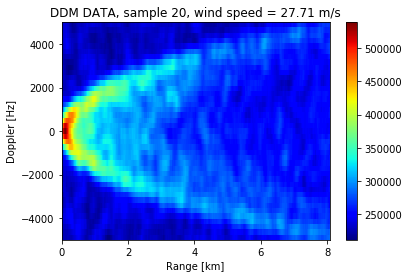

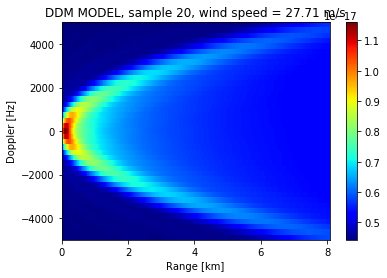

In [496]:
#Load data and models
ddm_file = "data/2017253_cyg06_Ant1_G16_cWF_20170910_051049ddm.nc"
ddmfile = netCDF4.Dataset(ddm_file, 'r')

tau_sd, doppler_sd, q_x, q_y, q_z, mlon, mlat, amb_flag = np.loadtxt("data/stare_dataCOV_PRN" + str(prn).zfill(2) + "_samp" + str(isamp).zfill(2) + ".txt", unpack=True)
ddm_mod_row = np.loadtxt("data/ddm_mod_PRN" + str(prn).zfill(2) + "_samp" + str(isamp).zfill(2) + ".txt", unpack=True)
ddm_stare_row = np.loadtxt("data/ddm_stare_PRN" + str(prn).zfill(2) + "_samp" + str(isamp).zfill(2) + ".txt", unpack=True)

noise_mod = 10.0**(ddm_mod_row[20001]/10.0) # 1st sample of doppler=0 wav
noise_dat = np.mean(ddmfile.variables['DDM'][isamp,20,0:200])

init_itau_data = 218
init_itau_model = 17
ndopplers = 41
ntaus = int(max(tau_sd[amb_flag == 1])/(299792458.0/16036200.0))

ddm_data = np.zeros([ndopplers, ntaus])
ddm_mod = np.zeros([ndopplers, ntaus])

ddm_da = []
ddm_ma = []
dop_diff = []

for itau in range(ntaus):
    for ifreq in range(ndopplers):
        ddm_data[ifreq, itau] = ddmfile.variables['DDM'][isamp,ifreq,itau + init_itau_data]
        ddm_mod[ifreq, itau] = 10.0**(ddm_mod_row[(ndopplers - ifreq - 1)*1000 + itau + init_itau_model]/10.0)
        if(amb_flag[itau*ndopplers + ifreq] == 1):
            ddm_da = np.append(ddm_da, ddm_data[ifreq, itau]/noise_dat - 1.0)
            ddm_ma = np.append(ddm_ma, ddm_mod[ifreq, itau]/noise_mod - 1.0)
            dop_diff = np.append(dop_diff, float(ifreq - 20)*250.0)

#Plot results            
plt.figure(1)
plt.imshow(np.flipud(ddm_data[:,:]), extent=[0.0, float(ntaus - 1)*(299792.458/16036200.0), -5000.0, 5000.0], cmap='jet', aspect='auto')
plt.colorbar()
plt.title("DDM DATA, sample %d, wind speed = %2.2f m/s" % (isamp, windfile.variables['windspeed'][isamp]))
plt.xlabel("Range [km]")
plt.ylabel("Doppler [Hz]")

plt.figure(2)
plt.imshow(np.flipud(ddm_mod[:,:]), extent=[0.0, float(ntaus - 1)*(299792.458/16036200.0), -5000.0, 5000.0], cmap='jet', aspect='auto')
plt.colorbar()
plt.title("DDM MODEL, sample %d, wind speed = %2.2f m/s" % (isamp, windfile.variables['windspeed'][isamp]))
plt.xlabel("Range [km]")
plt.ylabel("Doppler [Hz]")

plt.show()

Now, we will compare the normalized values along the non ambiguous cells.

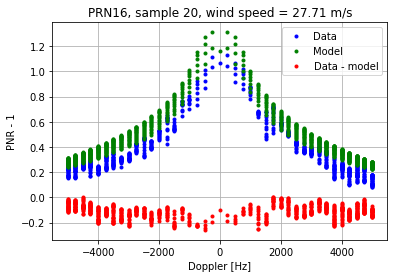

In [497]:
plt.figure(3)
plt.plot(dop_diff, ddm_da, 'b.', label="Data")
plt.plot(dop_diff, ddm_ma, 'g.', label="Model")
plt.plot(dop_diff, ddm_da - ddm_ma, 'r.', label="Data - model")
plt.title("PRN" + str(prn).zfill(2) + ", sample %d, wind speed = %2.2f m/s" % (isamp, windfile.variables['windspeed'][isamp]))
plt.xlabel("Doppler [Hz]")
plt.ylabel("PNR - 1")
plt.grid()
plt.legend()
plt.show()

## PDF retrieval

We proceed to the retrieval of the probability density function (PDF) of the surface's slopes. Given that the DDM contains both signal and noise and that DDM from data should be scaled to standard power units, we convert previous equation to get $P$ into:

\begin{equation}
P = (\mathrm{DDM}^{\mathrm{data}}N^{\mathrm{model}}_{P=1}/N^{\mathrm{data}} - N^{\mathrm{model}}_{P=1})/(\mathrm{DDM}^{\mathrm{model}}_{P=1} - N^{\mathrm{model}}_{P=1})
\end{equation}

where $N$ stands for the noise floor.

**IMPORTANT**: The next code segment should be executed after computing the DDM for all samples (running the previous part for *isamp* 0 till 57).

In [498]:
#Computation of theoretical PDF value
def PDFunction( surf, q, azimuthT, apply_gram_charlier ):
    qx = np.zeros(2)
    qxiw = np.zeros(2)
    #Anisotropy as a function of wind azimuth. If mss_x = mss_y (isotropy), phi has no effect over pdf.
    qx[0] = -q[0]/q[2]
    qx[1] = -q[1]/q[2]
    phi = (90.0 + azimuthT - surf.wind_U10_azimuth)*np.pi/180.0
    qxiw[0] = (qx[0]*np.cos(phi) + qx[1]*np.sin(phi))/np.sqrt(surf.mss_x)
    qxiw[1] = (qx[1]*np.cos(phi) - qx[0]*np.sin(phi))/np.sqrt(surf.mss_y)
    #Two-dimensional Gaussian distribution
    pdf = (1.0/(2.0*np.pi*np.sqrt(surf.mss_x*surf.mss_y)))*np.exp(-1.0*(qxiw[0]*qxiw[0] + qxiw[1]*qxiw[1])/2.0)
    if(apply_gram_charlier): #Gram-Charlier distribution (only for sea water)
        pdf = pdf*(1.0 + (surf.c21_coeff/2.0)*(qxiw[1]*qxiw[1] - 1.0)*qxiw[0] + (surf.c03_coeff/6.0)*(qxiw[0]*qxiw[0]*qxiw[0] - 3.0*qxiw[0]))
    return pdf

#Generation of all PDF values
file_out = open("data/q_lonlat_pdfs_PRN" + str(prn).zfill(2) + ".txt","w")

for isamp in range(58):
    
    print "-> In samp %d" % (isamp)
    tau_sd, doppler_sd, q_x, q_y, q_z, mlon, mlat, amb_flag = np.loadtxt("data/stare_dataCOV_PRN" + str(prn).zfill(2) + "_samp" + str(isamp).zfill(2) + ".txt", unpack=True)
    ddm_mod_row = np.loadtxt("data/ddm_mod_PRN" + str(prn).zfill(2) + "_samp" + str(isamp).zfill(2) + ".txt", unpack=True)
    ddm_stare_row = np.loadtxt("data/ddm_stare_PRN" + str(prn).zfill(2) + "_samp" + str(isamp).zfill(2) + ".txt", unpack=True)
    noise_mod = 10.0**(ddm_mod_row[20001]/10.0) # 1st sample of doppler=0 wav
    noise_dat = np.mean(ddmfile.variables['DDM'][isamp,20,0:200])
    DDMmodel.surface.wind_U10_speed = windfile.variables['windspeed'][isamp]
    DDMmodel.surface.wind_U10_azimuth = windfile.variables['winddir'][isamp]
    DDMmodel.surface.compute_mss_from_wind()
    DDMmodel.geometry.set_ECEFpos_Receiver([xecefR[isamp], yecefR[isamp], zecefR[isamp]])
    DDMmodel.geometry.read_ECEFpos_GNSS_Transmitter(sp3_file, int(gps_week[isamp]), gps_sow[isamp], prn, 'G')
    DDMmodel.geometry.compute_specular_point(1)
    
    for itau in range(ntaus):
        for ifreq in range(ndopplers):
            if(amb_flag[itau*ndopplers + ifreq] == 1):
                pdf_d = (ddmfile.variables['DDM'][isamp,ifreq,itau + init_itau_data]*noise_mod/noise_dat - noise_mod)/(10.0**(ddm_stare_row[(ndopplers - ifreq - 1)*1000 + itau + init_itau_model]/10.0) - noise_mod)
                pdf_m = (10.0**(ddm_mod_row[(ndopplers - ifreq - 1)*1000 + itau + init_itau_model]/10.0) - noise_mod)/(10.0**(ddm_stare_row[(ndopplers - ifreq - 1)*1000 + itau + init_itau_model]/10.0) - noise_mod)
                pdf_r = PDFunction(DDMmodel.surface, [q_x[itau*ndopplers + ifreq], q_y[itau*ndopplers + ifreq], q_z[itau*ndopplers + ifreq]], DDMmodel.geometry.azimuthT, True)
                file_out.write("%d %f %f %f %f %f %f %f %f %f %f %f %f %f %f %d\n" % (isamp, DDMmodel.geometry.longitudeS,  DDMmodel.geometry.latitudeS, windfile.variables['windspeed'][isamp], q_x[itau*ndopplers + ifreq], q_y[itau*ndopplers + ifreq], q_z[itau*ndopplers + ifreq], mlon[itau*ndopplers + ifreq], mlat[itau*ndopplers + ifreq], pdf_d, pdf_m, pdf_r, ddmfile.variables['DDM'][isamp,ifreq,itau + init_itau_data]/noise_dat, 10.0**(ddm_mod_row[(ndopplers - ifreq - 1)*1000 + itau + init_itau_model]/10.0)/noise_mod, 10.0**(ddm_stare_row[(ndopplers - ifreq - 1)*1000 + itau + init_itau_model]/10.0)/noise_mod, (ifreq - 20)*250))
                
file_out.close()

-> In samp 0
-> In samp 1
-> In samp 2
-> In samp 3
-> In samp 4
-> In samp 5
-> In samp 6
-> In samp 7
-> In samp 8
-> In samp 9
-> In samp 10
-> In samp 11
-> In samp 12
-> In samp 13
-> In samp 14
-> In samp 15
-> In samp 16
-> In samp 17
-> In samp 18
-> In samp 19
-> In samp 20
-> In samp 21
-> In samp 22
-> In samp 23
-> In samp 24
-> In samp 25
-> In samp 26
-> In samp 27
-> In samp 28
-> In samp 29
-> In samp 30
-> In samp 31
-> In samp 32
-> In samp 33
-> In samp 34
-> In samp 35
-> In samp 36
-> In samp 37
-> In samp 38
-> In samp 39
-> In samp 40
-> In samp 41
-> In samp 42
-> In samp 43
-> In samp 44
-> In samp 45
-> In samp 46
-> In samp 47
-> In samp 48
-> In samp 49
-> In samp 50
-> In samp 51
-> In samp 52
-> In samp 53
-> In samp 54
-> In samp 55
-> In samp 56
-> In samp 57


Now we can plot the results obtained for any sample:

In [499]:
noisy_samples = [36, 37, 38, 39]
lon_rang = 0.05
lat_rang = 0.2
samp, lonS, latS, wind, q_x, q_y, q_z, mlon, mlat, pdf_d, pdf_m, pdf_r, pnr_d, pnr_m, pnr_s, doppler = np.loadtxt("data/q_lonlat_pdfs_PRN" + str(prn).zfill(2) + ".txt", unpack=True)

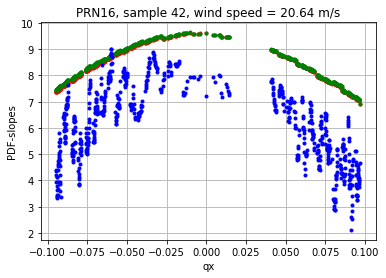

In [500]:
isamp = 42
lonS_samp = lonS[samp == isamp][0]
latS_samp = latS[samp == isamp][0]
wind_samp = wind[samp == isamp][0]
ind = (mlon[:] > (lonS_samp - lon_rang/2.0))&(mlon[:] < (lonS_samp + lon_rang/2.0))&(mlat[:] > (latS_samp - lat_rang/2.0))&(mlat[:] < (latS_samp + lat_rang/2.0))&(samp[:] != noisy_samples[0])&(samp[:] != noisy_samples[1])&(samp[:] != noisy_samples[2])&(samp[:] != noisy_samples[3])
plt.figure(4)
plt.plot(q_x[ind], pdf_r[ind], 'r.')
plt.plot(q_x[ind], pdf_m[ind], 'g.')
plt.plot(q_x[ind], pdf_d[ind], 'b.')
plt.grid()
plt.xlabel("qx")
plt.ylabel("PDF-slopes")
plt.title("PRN" + str(prn).zfill(2) + ", sample %d, wind speed = %2.2f m/s" % (isamp, wind_samp))
plt.show()

The plot above shows: (1) in red, theoretical PDF as a function of the X component of the scattering vector (has a larger variability than the Y component in this scenario); (2) in green, retrieved PDF using the DDM model, which compared against the previous parameter provides the distortion of the retrieval due to the approximation taken in the equation to get $P$; and (3) in blue, the PDF retrieved from real data. 

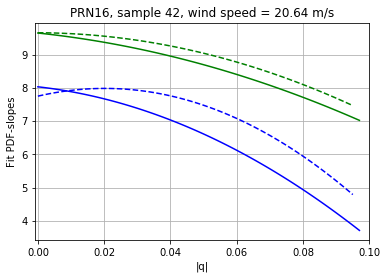

In [501]:
plt.figure(5)
ind_pD = (mlon[:] > (lonS_samp - lon_rang/2.0))&(mlon[:] < (lonS_samp + lon_rang/2.0))&(mlat[:] > (latS_samp - lat_rang/2.0))&(mlat[:] < (latS_samp + lat_rang/2.0))&(samp[:] != noisy_samples[0])&(samp[:] != noisy_samples[1])&(samp[:] != noisy_samples[2])&(samp[:] != noisy_samples[3])&(doppler[:] >= 0)
if(len(q_x[ind_pD]) > 3):
    q_abs = np.sqrt(q_x[ind_pD]*q_x[ind_pD] + q_y[ind_pD]*q_y[ind_pD])
    z = np.polyfit(q_abs, pdf_d[ind_pD], 2)
    p_d_pD = np.poly1d(z)
    z = np.polyfit(q_abs, pdf_m[ind_pD], 2)
    p_m_pD = np.poly1d(z)
    q_plot = np.arange(min(q_abs), max(q_abs), 0.001)
    plt.plot(q_plot, p_m_pD(q_plot), 'g-')
    plt.plot(q_plot, p_d_pD(q_plot), 'b-')
    
ind_mD = (mlon[:] > (lonS_samp - lon_rang/2.0))&(mlon[:] < (lonS_samp + lon_rang/2.0))&(mlat[:] > (latS_samp - lat_rang/2.0))&(mlat[:] < (latS_samp + lat_rang/2.0))&(samp[:] != noisy_samples[0])&(samp[:] != noisy_samples[1])&(samp[:] != noisy_samples[2])&(samp[:] != noisy_samples[3])&(doppler[:] <= 0)
if(len(q_x[ind_mD]) > 3):
    q_abs = np.sqrt(q_x[ind_mD]*q_x[ind_mD] + q_y[ind_mD]*q_y[ind_mD])
    z = np.polyfit(q_abs, pdf_d[ind_mD], 2)
    p_d_mD = np.poly1d(z)
    z = np.polyfit(q_abs, pdf_m[ind_mD], 2)
    p_m_mD = np.poly1d(z)
    q_plot = np.arange(min(q_abs), max(q_abs), 0.001)
    plt.plot(q_plot, p_m_mD(q_plot), 'g--')
    plt.plot(q_plot, p_d_mD(q_plot), 'b--')
    
plt.grid()
plt.xlabel("|q|")
plt.ylabel("Fit PDF-slopes")
plt.xlim([-0.001, 0.10])
plt.title("PRN" + str(prn).zfill(2) + ", sample %d, wind speed = %2.2f m/s" % (isamp, wind_samp))
plt.show()

This last plot provides a 2-order polynomial fit of the previous results (same color scheme) but splitting them into two groups depending on the sign of their relative Doppler frequency with respect to the specular point (positive -> solid line, negative -> dashed line). This approach enables the representation of the results as a function of the absolute value of the scattering vector (instead of taking one component).

## Gaussian analysis

Finally, we evaluate how the PDF obtained resembles a Gaussian function. The main purpose is to find a proper scalar metric that would enable an efficient cross-comparison between different samples. We select the kurtosis to achieve this objective. This parameter is equal to 3 for a Gaussian function. However, this is true whenever you measure it over its full range (as an approximation we could take plus minus three times sigma around the mean value). For a shorter interval, the measurement (or estimation in case of a noisy realization) of the kurtosis of a Gaussian function will differ from 3. For this reason, the evaluation of the kurtosis will be made in a differential mode by computing the difference between this parameter estimated from data or model and the one computed from its respective Gaussian fit. 

We define two basic functions required for kurtosis estimation and Gaussian fitting: 

In [502]:
from scipy.optimize import curve_fit

def func_gauss(x, A, mu, sigma):
   return A*np.sqrt(2.0*np.pi)*sigma*np.exp(-((x - mu)**2)/(2*sigma**2))

def compute_sigma_kurt(x, y):
   sigma_comp = np.sqrt(np.sum((x**2)*y/np.sum(y)))
   kurt_comp = np.sum((x**4)*y/np.sum(y))/sigma_comp**4
   return sigma_comp, kurt_comp

We can now plot the Gaussian fits applied to both data and model:

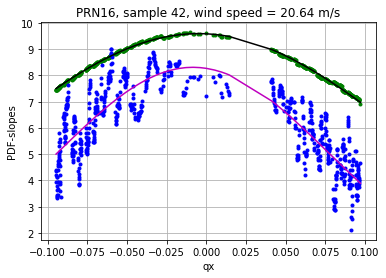

In [503]:
plt.figure(6)
plt.plot(q_x[ind], pdf_m[ind], 'g.')
plt.plot(q_x[ind], pdf_d[ind], 'b.')
#Gaussian analysis
indq = np.argsort(q_x[ind])
q_plot = q_x[ind][indq]
#Model
p_mod, cov_mod = curve_fit(func_gauss, q_plot, pdf_m[ind][indq], maxfev=100000)
plt.plot(q_plot, func_gauss(q_plot, p_mod[0], p_mod[1], p_mod[2]), 'k-')
sigma_mod, kurt_mod = compute_sigma_kurt(q_plot, pdf_m[ind][indq])
sigma_mod_fit, kurt_mod_fit = compute_sigma_kurt(q_plot, func_gauss(q_plot, p_mod[0], p_mod[1], p_mod[2]))
#Data
p_dat, cov_dat = curve_fit(func_gauss, q_plot, pdf_d[ind][indq], maxfev=100000)
plt.plot(q_plot, func_gauss(q_plot, p_dat[0], p_dat[1], p_dat[2]), 'm-')
sigma_dat, kurt_dat = compute_sigma_kurt(q_plot, pdf_d[ind][indq])
sigma_dat_fit, kurt_dat_fit = compute_sigma_kurt(q_plot, func_gauss(q_plot, p_dat[0], p_dat[1], p_dat[2]))
plt.grid()
plt.xlabel("qx")
plt.ylabel("PDF-slopes")
plt.title("PRN" + str(prn).zfill(2) + ", sample %d, wind speed = %2.2f m/s" % (isamp, wind_samp))
plt.show()

Finally, we can compare the sigma and kurtosis measurements obtained:

In [505]:
print "================= MODEL ================"
print "sigma: measured over input %f, over fit %f, true value from fit %f" % (sigma_mod, sigma_mod_fit, p_mod[2])
print "kurtosis: measured over input %f, over fit %f, difference %f" % (kurt_mod, kurt_mod_fit, kurt_mod - kurt_mod_fit)
print "================= DATA ================="
print "sigma: measured over input %f, over fit %f, true value from fit %f" % (sigma_dat, sigma_dat_fit, p_dat[2])
print "kurtosis: measured over input %f, over fit %f, difference %f" % (kurt_dat, kurt_dat_fit, kurt_dat - kurt_dat_fit)

================= MODEL ================
sigma: measured over input 0.068448, over fit 0.068446, true value from fit 0.127936
kurtosis: measured over input 1.307636, over fit 1.307350, difference 0.000286
================= DATA =================
sigma: measured over input 0.066464, over fit 0.066509, true value from fit 0.085700
kurtosis: measured over input 1.339142, over fit 1.342569, difference -0.003427
